# Assignment 2

# Question 1

In [1]:
# !wget https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/patches_256.zip -O content/patches_256.zip
# !unzip content/patches_256.zip -d content/
# !wget https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv -O content/protein_expression_data.csv


--2024-03-10 23:19:14--  https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 5335965 (5.1M) [text/csv]
Saving to: ‘protein_expression_data.csv’

protein_expression_ 100%[===================>]   5.09M  4.37MB/s    in 1.2s    

2024-03-10 23:19:16 (4.37 MB/s) - ‘protein_expression_data.csv’ saved [5335965/5335965]



In [39]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import rgb2hed, rgba2rgb
from skimage.io import imread

In [43]:
CONTENT_FOLDER = Path("content/")
IMAGE_FOLDER = CONTENT_FOLDER / Path("patches_256/")
EXPRESSION_DATA_FILE = CONTENT_FOLDER / Path("protein_expression_data.csv")

df = pd.read_csv(EXPRESSION_DATA_FILE)

In [44]:

df['specimen_id']=df.VisSpot.apply(lambda x: x.split('-')[2]) #create specimen id field
df['image_id']=df.VisSpot.apply(lambda x: x.split('-')[2])+'_'+df.id #create image id field
df = df.set_index('image_id').sort_index()
protein_names = ['SMAa', 'CD11b',
       'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 'CD24', 'TMEM119',
       'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 'NESTIN', 'TCIRG1',
       'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 'pERK', 'EGFR',
       'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 'MHCI', 'CD68',
       'CD14', 'KI67', 'CD16', 'SOX10']
print(df)

          Unnamed: 0                VisSpot  Location_Center_Y  \
image_id                                                         
A1_0x40          412  AAGTAAGCTTCCAAAC-1-A1         764.003658   
A1_0x42         7325  GTTTGAGCGGTTATGT-1-A1         799.511111   
A1_0x44         8102  TCACTCAGCGCATTAG-1-A1         832.902467   
A1_0x46         7085  GTGCGCTTACAAATGA-1-A1         858.343544   
A1_0x48         3748  CGAAGACTGCCCGGGA-1-A1         892.179831   
...              ...                    ...                ...   
D1_9x63         3609  CCTCCCGACAATCCCT-1-D1         123.760525   
D1_9x65          172  AACACGACTGTACTGA-1-D1          29.281573   
D1_9x67         2686  CACCGCCGACCAGCGA-1-D1         938.403662   
D1_9x69         2813  CAGAGTGATTTAACGT-1-D1         844.093656   
D1_9x71         6877  GTCAGTTGTGCTCGTT-1-D1         740.107483   

          Location_Center_X      SMAa     CD11b      CD44      CD31      CDK4  \
image_id                                                    

In [45]:
print("The number of examples for each specimen is as follows:")
print(df["specimen_id"].groupby(df["specimen_id"]).count())

The number of examples for each specimen is as follows:
specimen_id
A1    2894
B1    1145
C1    4129
D1    1753
Name: specimen_id, dtype: int64


The following is a collection of histograms representing the expression values of the proteins 'NESTIN', 'cMYC', and 'MET' for each specimen. The median for each is marked with a black dashed line.

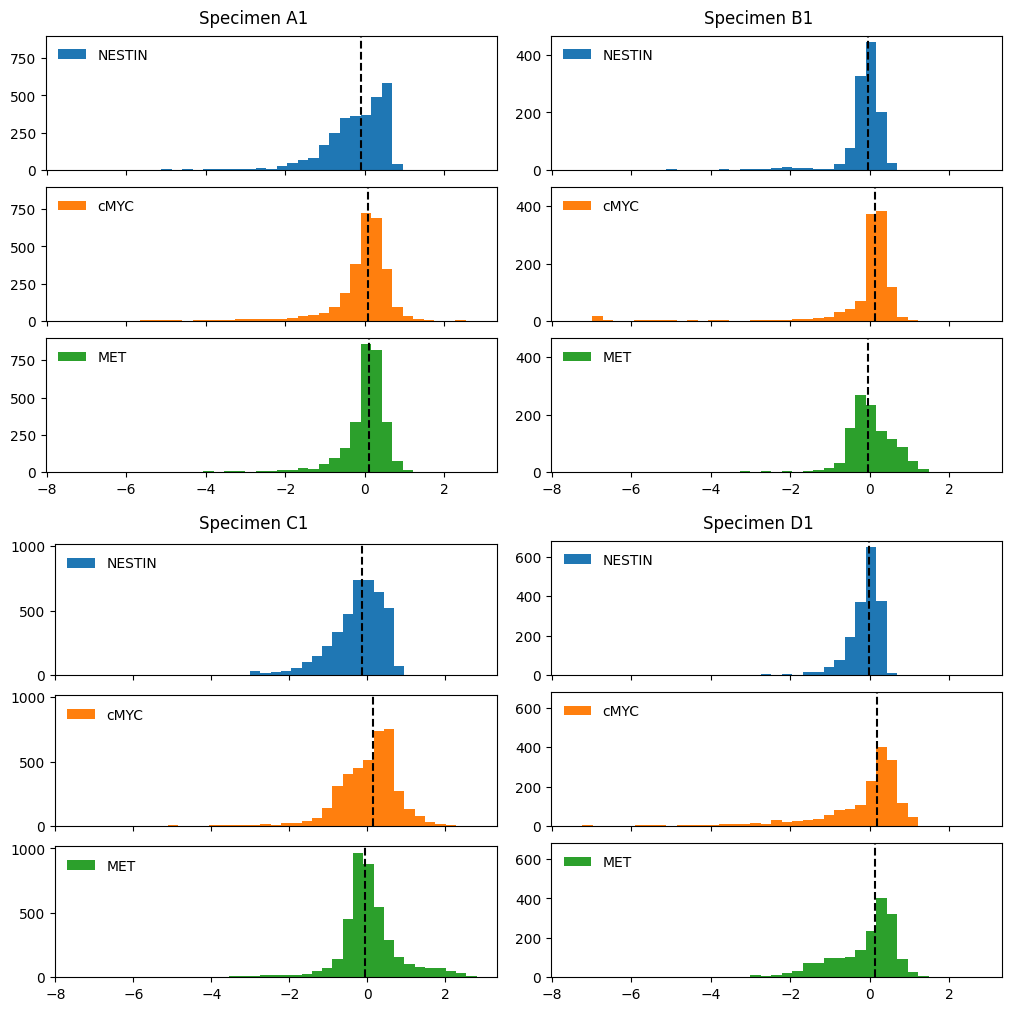

In [37]:
specimen_ids = df["specimen_id"].unique()
proteins_to_plot = ["NESTIN", "cMYC", "MET"]
num_bins = 30

# xbounds = (df[proteins_to_plot].min().min(), df[proteins_to_plot].max().max())
xbounds = (-7.5, 2.8)
bins = np.linspace(*xbounds, 40, endpoint=True)

fig = plt.figure(figsize=(10,10), layout="constrained")
subfigs = fig.subfigures(2,2)
for i, specimen_id in enumerate(specimen_ids):
    subfig = subfigs[i//2, i%2]
    axs = subfig.subplots(3, 1, sharex=True)
    df_specimen = df[df["specimen_id"]==specimen_id]
    for j, protein in enumerate(proteins_to_plot):
        axs[j].hist(df_specimen[protein], bins=bins, label=protein, color=f"C{j}")
        axs[j].legend(frameon=False, loc="upper left")
        axs[j].axvline(df_specimen[protein].median(), color="k", linestyle="--")
    subfig.suptitle(f"Specimen {specimen_id}")


for subfig in subfigs.flatten():
    lims = []
    for ax in subfig.get_axes():
        lims.append(ax.get_ylim())
    lims = list(zip(*lims))
    ybounds = (min(lims[0]), max(lims[1]))
    for ax in subfig.get_axes():
        ax.set_ylim(ybounds)
#

plt.show()

The distributions of the different proteins is broadly similar across the different specimens. The medians are all very close to 0 which is ideal as this suggests the data is already normalised. We will compare the distributions of each protein individually:
- NESTIN: B1 and D1 both have similar distributions with a smaller variance. A1 and C1 are similar with a larger variance and bigger left tail
- cMYC: B1 and D1 are again visually similar. A1 is more similar to these than to C1
- MET: All 4 distributions are quite varied.

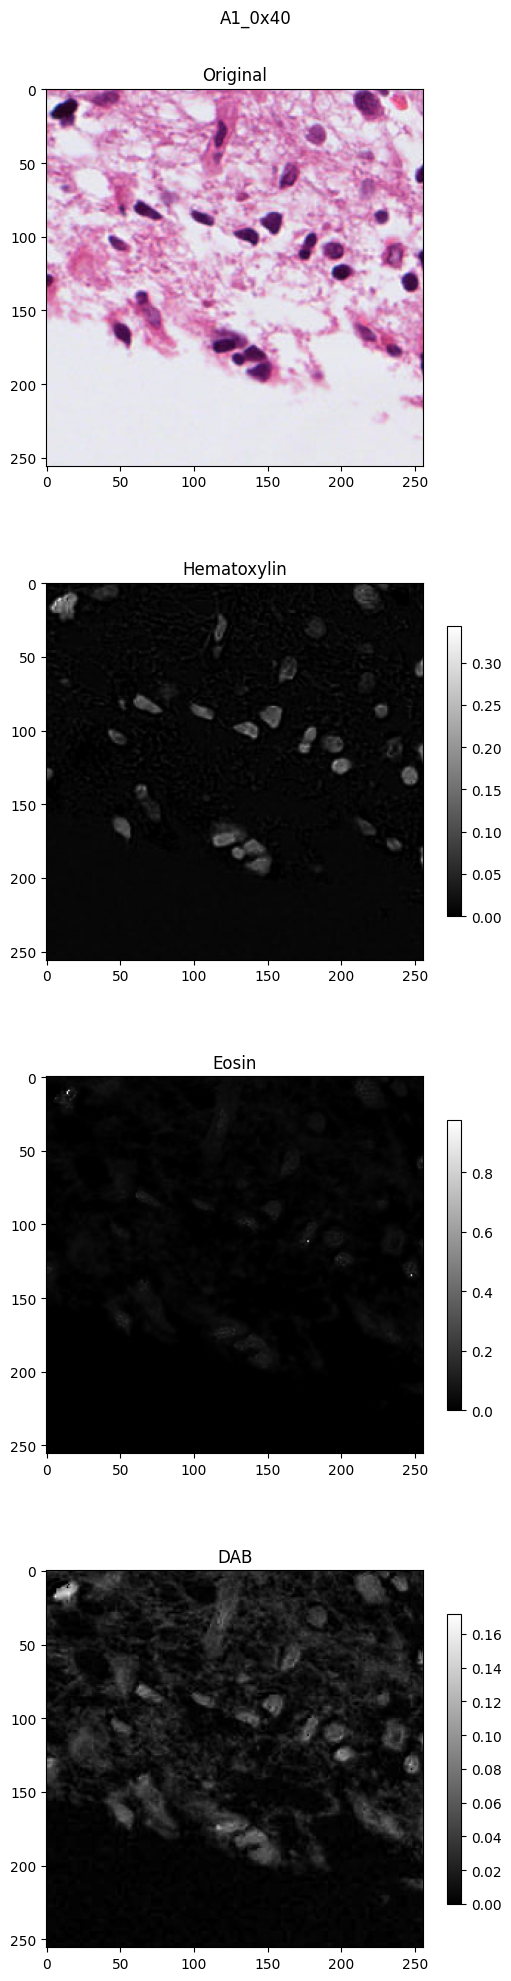

In [56]:
def load_image(image_id, image_folder=IMAGE_FOLDER):
    image_path = Path(image_folder) / f"{image_id}.png"
    im = rgba2rgb(imread(image_path))
    return im

def show_image(image_id, image_folder=IMAGE_FOLDER, show_hed=False):
    if not show_hed:
        im = load_image(image_id, image_folder)
        plt.imshow(im)
        plt.title(image_id)
        plt.show()
    else:
        im = load_image(image_id, image_folder)
        im_hed = rgb2hed(im)
        fig, axs = plt.subplots(4, 1, figsize=(5, 20), layout="constrained")
        axs[0].imshow(im)
        axs[0].set_title("Original")
        for i, channel in enumerate(["Hematoxylin", "Eosin", "DAB"]):
            imshow = axs[i+1].imshow(im_hed[:, :, i], cmap="gray")
            axs[i+1].set_title(channel)
            fig.colorbar(imshow, ax=axs[i+1], shrink=0.6)
        fig.suptitle(image_id)
        plt.show()

show_image(df.iloc[0].name, show_hed=True)